## Building Chris's Protocol deconfliction

ToDos:
- Still need cycling
- Trying to collect data on random, round robin, and backpressure to do some comparison w/ auction
    - Get data collection going, and data analysis
    - Get some better scenarios to test with
    - Read Chris's experimental protocol and replicate
    - Execute out and check


In [20]:
from helpers import *
from scipy.stats import norm

In [21]:
class Agent():
    
    def __init__(self, origin, dest, var_cost, depart_t = 0):
        
        """
        Initialize an Agent navigating the environment
        
        Input:
            origin: Hex, initial location
            dest: Hex, destination location
            var_cost: double, variable cost of operation
            depart_t: integer, time of departure
        Returns:
        
        """

        self._loc = -1   # -1 means grounded trying to enter air, 0 means arrived and down
        self._var_cost = var_cost

        # requested locations, payment costs and waiting costs
        self._steps = hex_linedraw(origin, dest)
        self._index = 0
        self._pay_costs = 0
        self._wait_costs = 0
        
        self._origin = origin
        self._dest = dest
        
        # departure and arrival times
        self._depart_t = depart_t
        self._schedule_t = depart_t + len(self._steps)
        self._arrival_t = None
        
        self._id = uuid.uuid4()
        
    @property
    def bid(self):
        """
        Send out bid of (loc, price, id)
        Returns:
            out: tuple of (loc, price, id)
        """
        if self._index >= len(self._steps): # if you're done
            # self._loc = 0  # return no bid, and set arrival flag
            return (None, -1, self._id)  
        
        # check that requested location is right next to current
        assert self._loc == -1 or hex_distance(self._steps[self._index], self._loc) == 1
        
        return (self._steps[self._index], self._var_cost, self._id)
    
    @property
    def loc(self):
        """
        Return current location
        Returns:
            out: Hex of location
        """
        return self._loc
    
    @property
    def dest(self):
        """
        Return destination
        Returns:
            out: Hex of location
        """
        return self._dest
    
    @property
    def finished(self):
        """
        Returns if agent has reached the destination
        Returns:
            out: bool
        """
        return self._loc == self._dest
    
    @property
    def costs(self):
        """
        Return costs incurred by agent so far
        This is essentially the extra costs incurred on top of costs from operatin w/o anyone else
        Returns:
            out: tuple of (pay_costs, wait_costs)
        """
        return (self._pay_costs, self._wait_costs)
    
    def move(self, command):
        """
        Move the bot
        Inputs:
            command: tuple of (next_loc, bid)
        Outputs:
            out: boolean to indicate at goal already
        """
        if self._index >= len(self._steps): return True  # if you're at the goal already
        
        next_loc, bid = command
        # if command is None, not cleared to move and you eat the variable cost
        if next_loc == None:
            self._wait_costs += self._var_cost
            return False
        
        # else move
        assert next_loc == self._steps[self._index]
        self._index += 1
        # del self._steps[0]
        self._loc = next_loc
        
        # pay the bid price
        self._pay_costs += bid
        return False

In [63]:
class Grid():
    """
    Contains the environment, the auctioneer
    
    Grid is small grid of 6 hexagons surrounding 7th center (q, r, s)
    
    
        (0, -1, 1)   (1, -1, 0)
    (-1, 0, 1)  (0,0,0)  (1, 0, -1)
        (-1, 1, 0)   (0, 1, -1)
    """
    
    
    def __init__(self, radius=1):
        """
        Creates Grid object
        
        Inputs:
            agents: list, agents in the environment

        """
        self._revenue = 0
        
        self.coords = create_hex_grid(radius)
        self.coords_l = list(self.coords)
        # if you want to do capacities, make a dictionary with {hex: capacity}
        
        # track the number of rounds an agent has been waiting {agent id: rounds waited}
        self._roundrobin = {}
        
        # track type of prioritization - default random
        # can be [random, roundrobin, backpressure]
        self._priority = "random"
        
        self.num_conflicts = 0
        self.radius = radius
        
    @property
    def revenue(self):
        """
        Returns current revenue of grid
        Returns:
            out: integer
        """
        return self._revenue
    
    @property
    def priority(self):
        return self._priority
    
    def set_priority(self, method):
        """
        Set the prioritization method
        Inputs:
            method: string of type of prioritization
        """
        assert method in ["random", "roundrobin", "backpressure", "secondprice", "secondback"]
        self._priority = method
        
    def step_sim(self, locations, bids):
        """
        Step through one step of Chris's protocol - this handles cycles on until hold/motion (lines 4 to 24 in Alg 1)
        Inputs:
            locations: {id : loc} all active agent locations (if you're trying to depart also active)
            bids: {id : (next_loc, price)} all active agent bids
        Returns:
            commands: dictionary of tuples {id : (next loc, winning price)} of size (# agents) (None, 0) means hold
        """
        # price = -1 means it's still undecided 
        # price = 0 means it's on hold
        # init commands
        commands = {_id: (None, -1) for (_id, (_, _)) in bids.items()}
        
        # build node graph - all departing flights are treated as coming from one massive ground node -1
        in_graph = {}   # inverse graph - points from inbound to outbound
        requests = {}   # dictionary of all locations requested and hwho's requesting
        for loc, (_id, (next_loc, price)) in zip(locations.values(), bids.items()):

            if price == -1: continue
            assert loc == -1 or loc in self.coords, "Coordinate does not exist in the grid"
            
            # build graph for cycle and backpressure
            if next_loc in in_graph.keys(): in_graph[next_loc].append(loc)
            else: in_graph[next_loc] = [loc]
            
            # buidl the request list - essentially all the bid info the agents gave
            # right now its {location: (id, stated value)}            
            if next_loc not in requests: requests[next_loc] = []
            requests[next_loc].append((_id, price))
            
            # add to round robin priority list
            if _id not in self._roundrobin: self._roundrobin[_id] = 0

        # print("graph\n", in_graph)
        # identify cycles (skipping for now)
        # print('requests', requests)
        cycle_ids = []
        for req in requests.keys():
            temp = self.find_cycles(in_graph, req)
            for loc in temp:
                count = 0
                for _id in locations.keys():
                    if _id not in cycle_ids and locations[_id] == loc and bids[_id][0] in temp and count < CAPACITY:
                        cycle_ids.append(_id)
                        count += 1
                        
        # print("cycling _id", cycle_ids)
        for _id in cycle_ids:
            commands[_id] = bids[_id]
        
        
        # calculate backpressure and sort - order is which sectors to deconflict first
            # NOTE: both backpressure and cycles requires building a graph at each step
        pressures = {req: self.calc_backpressure(in_graph, req) for req in requests.keys()}
        order = sorted(requests, key=lambda req: pressures[req], reverse=True)

        # handling every sector now
        for loc in order:
            asks = requests[loc]
            
            # print(asks)
            # assert 1 == 0
            
            # create a list of (index, price of bid)
            undecided = []
            decided = []
            for (_id, price) in asks:
                if commands[_id][1] == -1: undecided.append((_id, price))
                else: decided.append((_id, price))

            # resolve capacities
            # check if you still have capacity
            assert len(decided) <= CAPACITY, print(decided, "\n", locations, "\n", bids, "\n", commands, "\n", loc)
            if len(decided) < CAPACITY:
                
                # if you still have capacity 
                if len(undecided) <= CAPACITY - len(decided):

                    # function for moving undecided into G (aka all go)
                    # the 4 line block is the key
                    # assert bids[i][0] == loc
                    for i in range(len(undecided)):
                        (win_i, price) = undecided.pop(i)
                        commands[win_i] = (bids[win_i][0], 0)   # append comamnd
                        self._revenue += 0
                        decided.append((win_i, price))
                        
                # if you don't have capacity and have to decide
                else: 
#                     print("contested", loc)
                    self.num_conflicts += 1
                    while CAPACITY > len(decided):
                        
                        #PRIORITIZATION METHODS - win returns id of winning agent
                        if self._priority == "roundrobin": 
                            win, win_id, price = self.roundrobin_prioritization(undecided)
                            undecided.pop(win)
                        elif self._priority == "backpressure": 
                            win, win_id, price = self.backpressure_prioritization(undecided, locations, in_graph)
                            undecided.pop(win)
                        elif self._priority == "secondprice" :
                            win, win_id, price = self.secondprice_prioritization(undecided)
                            undecided.pop(win)
                        elif self._priority == "secondback":
                            win, win_id, price, moves = self.secondback_prioritization(undecided, locations, in_graph, bids)
                            undecided.pop(win)
                        else: 
                            win, win_id, price = self.random_prioritization(undecided)   # PRIORITIZATION using random prioritization
                            undecided.pop(win)
                            
                        if self._priority == "secondback":
                            # print(commands)
                            for move_id, move_price in moves:
                                commands[move_id] = [bids[move_id][0], move_price]
                            # print(commands)
                            
                        else:
                            commands[win_id] = (bids[win_id][0], price)

                        self._revenue += price
                        decided.append((win_id, price))
                        # assert 1 == 0
                        
            # end dealing with the sector - mark undecided as hold
            for (_id, price) in undecided:
                commands[_id] = (None, 0)
                self._roundrobin[_id] += 1
                if locations[_id] in requests: requests[locations[_id]].append((_id, price))

        # print("locs", locations)
        # print("bids", bids)
        # print("comms", commands)
        return commands


    
    def random_prioritization(self, undecided, seed = None):
        """
        Random prioritization method by merged queue, flight
        Inputs:
            undecided: list of tuples (index, price) of undecided flights
            seed: RNG seeder
        Returns:
            high_index: integer of an index in undecided
            win_id: id of winning agent
            price: price the agent pays
        """
        if seed: rand = np.random.default_rng(seed)
        else: rand = np.random.default_rng()
        
        win = rand.integers(len(undecided))
        (win_id, price) = undecided[win]
                                                                             
        return win, win_id, price
    
    def roundrobin_prioritization(self, undecided):
        """
        Trying to set up round robin prioritization around the grid
        If tied, first instance in undecided gets to go
        Inputs:
            undecided: list of tuples (index, price) of undecided flights
        Returns:
            high_index: integer of an index in undecided
            win_id: id of winning agent
            price: price the agent pays
        """
        
        high_wait = 0
        high_index = 0
        
        # find the highest wait
        for i, (_id, price) in enumerate(undecided):
            if self._roundrobin[_id] > high_wait:
                high_wait = self._roundrobin[_id]
                high_index = i
        
        # set highest wait to 0, b/c they're getting to move
        self._roundrobin[undecided[high_index][0]] = 0
        
        (win_id, price) = undecided[high_index]
                                                                             
        return high_index, win_id, price
        
        
    def backpressure_prioritization(self, undecided, locations, graph):
        """
        Using backpressure to resolve conflicts
        Inputs:
            undecided: list of tuples (_id, price) of undecided flights
            locations: {id:Hex} dictionary of all locations of agents
            graph: dictionary of Hex {inbound sector: [outbound sectors]}
        Returns:
            high_index: integer of current flights following
        """
        
        high_press = 0
        high_index = 0
        
        # find the highest backpressure
        for i, (_id, price) in enumerate(undecided):
            back_press = self.calc_backpressure(graph, locations[_id])
            
            if back_press > high_press:
                high_press = back_press
                high_index = i
       
        (win_id, price) = undecided[high_index]
                                                                             
        return high_index, win_id, price
    
    
    def secondprice_prioritization(self, undecided):
        """
        Sealed second price auction for locations - single square bid
    
        Inputs:
            requests: dictionary of (loc, (agent_id, bid)) to resolve
            num_agents: number of agents bidding
        
        Returns:
            output: list of tuples (next loc, winning bid) of size (# agents)
        """
        
        # get high bid
        high_index, winner = max(enumerate(undecided), key=lambda x:x[1][1])
        # print(undecided)
        
        # get price of second bid
        new = set(undecided)
        new.remove(winner)
    
        if not new: price = 0
        else: price = max(new, key=lambda x: x[1])[1]
    
        # self._revenue += price
        
        # print(high_index, winner, price)
        
        return high_index, winner[0], price
        
    def secondback_prioritization(self, undecided, locations, graph, bids):
        """
        Inputs:
            undecided: list of tuples (_id, price) of undecided flights
            locations: {id:Hex} dictionary of all locations of agents
            graph: dictionary of Hex {inbound sector: [outbound sectors]}
            bids: {id : (next_loc, price)} all active agent bids
        Outputs:
            
        """
        
        # calculate sum total value on every chain
        # create inverted locations dictionary - should be one to one IF capacity = 1
        assert CAPACITY <= 1, "Change this entire setup"
        invlocations = {v: k for k, v in locations.items()}
        # for every undecided branch
            # recursive helper function - input of undecided, graph - append that node's value to
        chains = [] # store chains
        for (_id, _) in undecided:

            chains.extend(self.secondback_helper(locations, invlocations, graph, bids, _id))

        for chain in chains:
            chain["total"] = sum(chain["price"])

        # print("chains\n", chains)
        # find the winner and price
            # search like in second price
        
        # high_index, winner = max(enumerate(chains), key=lambda c: c[1]["total"])
        
        # # new = set(chains)
        # # new.remove(winner)
        # # print(chains)
        # chains.remove(winner)

        # if not chains: price = 0
        # else: price = max(chains, key=lambda x: x["total"])["total"]
        
        chains = sorted(chains, key = lambda c: c["total"], reverse=True)
        # print(chains)
        winner = chains[0]
        price = chains[1]["total"]
        
        high_index = None
        for j, (_id, _) in enumerate(undecided):
            if not high_index and _id == winner["chain"][-1]:
                high_index = j

        # print(chains)
        # print(winner, high_index)
        # print(price)

        # commands
        commands = []
        for _id, bid in zip(winner["chain"], winner["price"]):
            if winner["total"] == 0:
                cost = 0
            else:
                cost = float(bid / winner["total"]) * price

            commands.append((_id, cost))
        
        # print(high_index, winner["chain"][-1], price, commands)

        return high_index, winner["chain"][-1], price, commands

        # clear the conflicts that have been resolved
            # this could be done by making sure all the commands are logged, then
            # the backpressure sort will enforce decided category
        
        # output commands - list the winners and the price paid, using proportional 

    
    def secondback_helper(self, locations, invlocations, graph, bids, _id):
        """
        Assume for now that it's just one transition every time - can break this problem later
        
        Return a []
        """
        
        # take in an _id
        
        in_loc = locations[_id]
        # print("helper", _id, in_loc)
        # base case - there's no inbound to this id, so no entry in graph
        if in_loc == -1 or in_loc not in graph:
            return [{"chain": [_id], "price": [bids[_id][1]]}]
        
        # run the function on outbound locations from graph, being careful of -1
        # get # get the location from locations - inverted lookup location from locations - inverted lookup
            # duplicate a query for every outbound sector listed
        chains = []
        for out_loc in graph[in_loc]:
            # dealing with the -1 case
            out_id = None
            if out_loc == -1:

                for test_id, hex in locations.items():
                    if not out_id and hex == -1 and bids[test_id][0] == in_loc:
                        out_id = test_id
                
                # print("-1", out_id)

                chain_add = [{"chain": [out_id], "price": [bids[out_id][1]]}]

            else:   
                out_id = invlocations[out_loc]

            # print(out_id)
                chain_add = self.secondback_helper(locations, invlocations, graph, bids, out_id)
                       
            chains += chain_add
        
        
        # look up price and sum to every element of [chain, chain, ....] returned from above
            # where chain is {chain: [_ids], price: int}
        
        for chain in chains:
            chain["chain"].append(_id)
            chain["price"].append(bids[_id][1])
        
        # return that array of chains
        # print("helper", chains)
        return chains
    
    def find_cycles(self, graph, request, incoming = []):
        """
        Recursive function that finds the cycles active 
        """
        # if the request isn' in the graph, or all elements in [outgoing] are takeoff requests (-1)
        # or the recursion is too deep, there is no cycle and return []
        if request in graph.keys():
            new_ag = True
            for req in graph[request]:
                if req != -1:
                    new_ag = False
        
            if new_ag or len(incoming) > 50:
                return []
        else:
            return []
            
        # if request not in graph.keys() or graph[request][0] == -1 or len(incoming) > 50:
            # return []
  
        # cycle detection, you've found yourself in your own incoming chain
        if request in incoming:
            # print("req", request)
            # print("incoming", incoming)
            return incoming
        
        # recursive call, if pressures is anything it'll return the cycle
        pressures = []
        incoming.append(request)
        for req in graph[request]:
            pressures += self.find_cycles(graph, req, incoming)
        
        incoming.pop()
        return pressures
    
    
    def calc_backpressure(self, graph, request, depth = 0):
        """
        Calculate backpressure recursively, by starting from conflicted sectors
        and following inbound flights
        Inputs:
            graph: dictionary of Hex {inbound sector: [outbound sectors]}
            request: Hex of inbound sector to calculate backpressure from
            incoming: runnign record of 
            //depth: max depth of recursion
        Returns:
            out: integer of current flights following
        """
        # if the request isn' in the graph, or all elements in [outgoing] are takeoff requests (-1)
        # or the recursion is too deep, there is no cycle and return 0
        
        if request in graph.keys():
            new_ag = True
            for req in graph[request]:
                if req != -1:
                    new_ag = False
            
            if new_ag or depth > 50:
                return 0
        else:
            return 0

        # recursion to catch the rest of the pressures
        pressures = [self.calc_backpressure(graph, req, depth + 1) for req in graph[request]]
        return max(pressures) + 1
        

In [23]:
def create_random(num_agents = 1, radius = 1, iters = 10, seed = None):
    """
    Creates a grid, list of agents, and the schedule in which they deploy
    Inputs:
        radius: size of grid
        iters: iterations planned
        seed: seed for random number generator
    Outputs: (grid, agents, schedule)
        grid: the map we're operating on
        agents: list of all agents that will join the system during the sim
        schedule: time at which agents depart and join system
    """
    rand = np.random.default_rng(seed)
    grid = Grid(radius)

    # Agents get random OD and random departure time (arrival time judged by steps to there)
    # create radius # of agents, store schedule of when agents go to active list
    agents = []
    schedule = {}
    for _ in range(num_agents):
        
        
        OD = rand.integers(0, len(grid.coords_l), size=2)
        init_time = rand.integers(0, iters - radius)
        var_cost = rand.integers(1, 10)
        
#         print(grid.coords_l[OD[0]], grid.coords_l[OD[1]], init_time)
        ag = Agent(grid.coords_l[OD[0]], grid.coords_l[OD[1]], var_cost, init_time)
        agents.append(ag)
        
        if init_time in schedule.keys(): schedule[init_time].append(ag)
        else: schedule[init_time] = [ag]
        
        # store and release from active_agents list
        # have grid process and understand bids - will need wait times and queuing data stored w/ agents
    
    return grid, agents, schedule

    
create_random(num_agents = 3, radius = 3, iters = 10)

(<__main__.Grid at 0x26e6bedd6d8>,
 {5: [<__main__.Agent at 0x26e6beddc18>],
  0: [<__main__.Agent at 0x26e6bedd780>],
  6: [<__main__.Agent at 0x26e6beddda0>]})

In [24]:
def create_binomial(num_agents = 62, radius = 1, time = 50, seed = None):
    """
    
    """
    rand = np.random.default_rng(seed)
    grid = Grid(radius)
    var_cost = 2
    
    weights_loc = rand.random(len(grid.coords_l))
    weights_loc = weights_loc / np.sum(weights_loc)
    
    x = np.linspace(0, time)
    weights_t = norm.pdf(x, 40, 5) + norm.pdf(x, 20, 8)
    weights_t = weights_t / np.sum(weights_t)
    
    agents = []
    schedule = {}
    for _ in range(num_agents):
        
        OD = rand.choice(len(grid.coords_l), size = 2, replace = False, p = weights_loc)
        init_time = rand.choice(time, p = weights_t)
        var_cost = rand.integers(1, 10)
        
#         print(grid.coords_l[OD[0]], grid.coords_l[OD[1]], init_time)
        ag = Agent(grid.coords_l[OD[0]], grid.coords_l[OD[1]], var_cost, init_time)
        agents.append(ag)
        
        if init_time in schedule.keys(): schedule[init_time].append(ag)
        else: schedule[init_time] = [ag]
        
        # store and release from active_agents list
        # have grid process and understand bids - will need wait times and queuing data stored w/ agents
    
    return grid, agents, schedule

# create_binomial(radius = 6)

In [25]:
def create_connected(radius = 1, iters = 10, seed = None):
    """
    Creates a grid, list of agents, and the schedule in which they deploy
    This setup is two lines of agents all trying to go to (0,0,0)
    Inputs:
        radius: int, size of grid
        iters: int, iterations planned
        seed: int, seed for random number generator
    Outputs: (grid, agents, schedule)
        grid: Grid, the map we're operating on
        agents: list of Agents, all agents that will join the system during the sim
        schedule: dictionary of {time: [Agents]} times at which agents depart and join system
    """
    assert radius >= 3
    
    rand = np.random.default_rng(seed)
    
    grid = Grid(radius)

    # Agents get random OD and random departure time (arrival time judged by steps to there)
    # create radius # of agents, store schedule of when agents go to active list
    agents = []
    schedule = {}
    for i in range(1, radius):
        
        init_time = 0
        var_cost = 2
        ag = Agent(Hex(i, -i, 0), Hex(0, 0, 0), var_cost, init_time)
        agents.append(ag)
        
        if init_time in schedule.keys(): schedule[init_time].append(ag)
        else: schedule[init_time] = [ag]
    
    # opposing line of agents
    for i in range(1, radius-1):
        
        init_time = 0
        var_cost = 2
        ag = Agent(Hex(i, 0, -i), Hex(0, 0, 0), var_cost, init_time)
        agents.append(ag)
        
        if init_time in schedule.keys(): schedule[init_time].append(ag)
        else: schedule[init_time] = [ag]
        
#         # store and release from active_agents list
#         # have grid process and understand bids - will need wait times and queuing data stored w/ agents
    
    return grid, agents, schedule

create_connected(4)

(<__main__.Grid at 0x26e6b766d30>,
 {0: [<__main__.Agent at 0x26e6b766518>,
   <__main__.Agent at 0x26e61f3b668>]})

In [26]:
## Build a data structure to keep track of all the sim stuff
# this should be pickle
"""
{
each time: agent locations (not locs, both active and silent), agent finished bool, bids, commands

overall: grid revenue, schedule, agents
}
"""

'\n{\neach time: agent locations (not locs, both active and silent), agent finished bool, bids, commands\n\noverall: grid revenue, schedule, agents\n}\n'

In [100]:
def simulate(grid, agents, schedule, prior = None, iters = 1e4, seed = 0, vis = False, debug = False, output=False):
    """
    Simulation function to run everything
    Not dealing with cycles
    Inputs:
        grid: Grid
        agents: list of Agents
        schedule: dictionary of {time: [Agents]}, when each agent starts up
        *****
        priority: string, type of priority method grid uses, default None -> random
        iters: int of iterations, optional
        seed: int for RNG, optional
        vis: bool for visualization, optional
        debug: bool for text debugging, optional
    Returns:
        revenue:
        delay:
        std delay:
        num_conflicts
        pay costs:
        wait costs:
        weighted std delay
        normalized pay costs:
        normalized wait costs:
    """
    
    ## Initialization
    # Grid setup
    if prior is not None: grid.set_priority(prior)
    
    # Data collection setups
    delays = {}
    

    ## Running the simulation
    active = []    
    time = 0
    
    layout = Layout(layout_pointy, Point(1, 1), Point(0, 0))
    
    while time <= iters:

        if vis or debug: print("Time: ", time)
        
        # plotting and visualization

        if vis: plot_locations(layout, grid.coords_l, active, radius = grid.radius)
        
        # for debugging, print all agent locations
        if debug:
            for ag in agents: 
                print("Agent", ag._id, "location", ag.loc, "target", ag.dest, ag.finished)
        
        # update the active agents list
        for ag in active:
            if ag.finished:
                ag._arrival_t = time
        

        # check if all agents are in, which would indicate END ****
        if all([x.finished for x in agents]): break
        
            
        active = [ag for ag in active if not ag.finished]
        if time in schedule.keys(): active += schedule[time]
        
        # get bids and locations
        bids = {}
        locs = {}
        for ag in active:
            next_loc, price, _id = ag.bid
            bids[_id] = (next_loc, price)
            # bids.append(ag.bid)
            locs[_id] = ag.loc

            
        # Run the step simulation
        commands = grid.step_sim(locs, bids)
        if debug:
            print("Bids: ", bids)
            print("Commands: ", commands)
        
        # move agents around
        for i, command in enumerate(commands.values()):
            active[i].move(command)
            
        time += 1
    
    
    if output:
        print("Time: ", time)
        print("Priority: ", grid.priority)

    delays = []
    delays_weighted = []
    agent_waits = []
    agent_waits_norm = []
        # get costs and revenue
    for i, ag in enumerate(agents):
        if output: 
            print("Agent ", i, " costed ", ag.costs, "finished", ag.finished, "departure, scheduled, arrived", ag._depart_t, ag._schedule_t, ag._arrival_t, "price", ag._var_cost)   # think of this as extra/delayed costs
            
        delays.append(ag._arrival_t - ag._schedule_t)
        delays_weighted.append((ag._arrival_t - ag._schedule_t) * ag._var_cost)
        agent_waits.append(np.array(ag.costs))
        agent_waits_norm.append(np.array(ag.costs) / ag._var_cost)
        
    agent_waits = np.array(agent_waits)
    agent_waits_norm = np.array(agent_waits_norm)
    # print(agent_waits)
    if output:
        print("Total Revenue: ", grid.revenue)
        print("Total Conflicts: ", grid.num_conflicts)
        print("Total Delay: ", np.sum(delays))
        print("Std Dev Delay: ", np.std(delays))
        print("Total Pay Costs: ", np.sum(agent_waits[:, 0]))
        print("Total Wait Costs: ", np.sum(agent_waits[:, 1]))
        
        print("Std Dev Normalized Delay: ", np.std(delays_weighted))

        print("Total Normalized Pay Costs: ", np.sum(agent_waits_norm[:, 0]))
        print("Total Normalized Wait Costs: ", np.sum(agent_waits_norm[:, 1]))
    

    return grid.revenue, np.sum(delays), np.std(delays), grid.num_conflicts, np.sum(agent_waits[:, 0]), np.sum(agent_waits[:, 1]), np.std(delays_weighted), np.sum(agent_waits_norm[:, 0]), np.sum(agent_waits_norm[:, 1])

In [101]:
## testing
# grid size = sum(1 to n) * 6 + 1
# grid, agents, schedule = create_random(num_agents=5, radius = 2, seed = 10)
# seed = np.random.randint(1000)
# print(seed)
grid, agents, schedule = create_random(num_agents=50, radius=3, iters=20, seed=12)

# grid, agents, schedule = create_connected(radius=4)
# grid, agents, schedule = create_binomial(num_agents = 62, time = 50, radius = 3)
for i, ag in enumerate(agents):
    ag._id = i
    # ag._var_cost = 5 - i
    # print(ag._steps[0], ag.loc)
#     ag.move((ag._steps[0], 0))
rev, delay, std_delay, _, _, _, _, _, _ = simulate(grid, agents, schedule, vis= False, prior="secondback", output=True, debug=False)

Time:  23
Priority:  secondback
Agent  0  costed  (0, 0) finished True departure, scheduled, arrived 16 20 20 price 9
Agent  1  costed  (0, 0) finished True departure, scheduled, arrived 3 5 5 price 2
Agent  2  costed  (3.4457142857142857, 6) finished True departure, scheduled, arrived 8 14 16 price 3
Agent  3  costed  (2.0, 10) finished True departure, scheduled, arrived 11 13 18 price 2
Agent  4  costed  (9.0, 0) finished True departure, scheduled, arrived 5 10 10 price 8
Agent  5  costed  (5.0, 5) finished True departure, scheduled, arrived 8 14 15 price 5
Agent  6  costed  (0, 12) finished True departure, scheduled, arrived 12 17 21 price 3
Agent  7  costed  (6.0, 0) finished True departure, scheduled, arrived 5 10 10 price 5
Agent  8  costed  (23.789473684210527, 18) finished True departure, scheduled, arrived 12 17 19 price 9
Agent  9  costed  (2.857142857142857, 14) finished True departure, scheduled, arrived 9 14 21 price 2
Agent  10  costed  (9.058823529411764, 9) finished Tru

In [102]:
## Try multiple runs of different tests
methods = ["random", "roundrobin", "backpressure", "secondprice", "secondback"]

data_avg_rev = []
data_avg_del = []
data_avg_std = []
data_avg_confl = []

data_avg_wait = []
data_avg_pay = []

data_avg_std_weighted = []

data_avg_wait_norm = []
data_avg_pay_norm = []

for priority in methods:
    avg_rev = 0
    avg_del = 0
    avg_std_del = 0
    avg_num_conflicts = 0

    avg_pay_costs = 0
    avg_wait_costs = 0

    avg_std_del_weighted = 0

    avg_pay_costs_norm = 0
    avg_wait_costs_norm = 0

    # if priority == "secondprice" or priority == "secondback":
    #     avg__pay_costs = 0
    samples = 100

    for i in range(samples):
        # seed = np.random.randint(1000)
        # print(seed)
        # print(i)
        # grid, agents, schedule = create_random(num_agents=124, radius=7, iters=50)
        grid, agents, schedule = create_binomial(num_agents=124, radius=7, time=50)
        rev, delay, std_delay, conflicts, pay_costs, wait_costs, std_delay_weighted, pay_costs_norm, wait_costs_norm = simulate(grid, agents, schedule, vis= False, prior=priority)
        avg_rev += rev
        avg_del += delay
        avg_std_del += std_delay
        avg_num_conflicts += conflicts

        avg_pay_costs += pay_costs
        avg_wait_costs += wait_costs

        avg_std_del_weighted += std_delay_weighted

        avg_pay_costs_norm += pay_costs_norm
        avg_wait_costs_norm += wait_costs_norm

    
    print("Priority: ", priority)
    print("Avg Revenue: ", avg_rev / samples)
    print("Avg Delay: ", avg_del / samples)
    print("Avg Std Dev Delay (among agents): ", avg_std_del / samples)
    print("Avg Num Conflicts: ", avg_num_conflicts / samples)

    print("Avg payment costs: ", avg_pay_costs / samples)
    print("Avg waiting costs: ", avg_wait_costs / samples)

    print("Avg Weighted Std Dev Delay (among agents): ", avg_std_del_weighted / samples)
    
    print("Avg Normalized payment costs: ", avg_pay_costs_norm / samples)
    print("Avg Normalized waiting costs: ", avg_wait_costs_norm / samples)

    data_avg_rev.append(avg_rev / samples)
    data_avg_del.append(avg_del / samples)
    data_avg_std.append(avg_std_del / samples)
    data_avg_confl.append(avg_num_conflicts / samples)

    data_avg_pay.append(avg_pay_costs / samples)
    data_avg_wait.append(avg_wait_costs / samples)

    data_avg_std_weighted.append(avg_std_del_weighted  / samples)

    data_avg_pay_norm.append(avg_pay_costs_norm / samples)
    data_avg_wait_norm.append(avg_wait_costs_norm / samples)


Priority:  random
Avg Revenue:  343.47
Avg Delay:  145.81
Avg Std Dev Delay (among agents):  1.680186651013459
Avg Num Conflicts:  68.65
Avg payment costs:  675.86
Avg waiting costs:  731.03
Avg Weighted Std Dev Delay (among agents):  9.948891181571344
Avg Normalized payment costs:  135.45
Avg Normalized waiting costs:  145.81
Priority:  roundrobin
Avg Revenue:  360.75
Avg Delay:  151.12
Avg Std Dev Delay (among agents):  1.5838642130840836
Avg Num Conflicts:  71.7
Avg payment costs:  680.93
Avg waiting costs:  762.7
Avg Weighted Std Dev Delay (among agents):  9.45988718341422
Avg Normalized payment costs:  135.43
Avg Normalized waiting costs:  151.12
Priority:  backpressure
Avg Revenue:  369.25
Avg Delay:  110.1
Avg Std Dev Delay (among agents):  1.2174312099628697
Avg Num Conflicts:  73.32
Avg payment costs:  651.93
Avg waiting costs:  558.03
Avg Weighted Std Dev Delay (among agents):  7.311830140038441
Avg Normalized payment costs:  130.11
Avg Normalized waiting costs:  110.1
Priori

Text(0, 0.5, 'stdev delay')

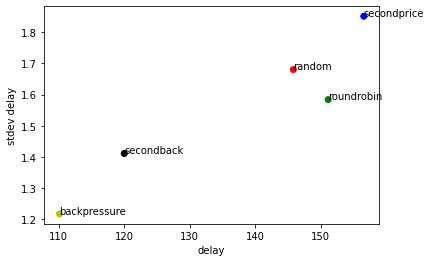

In [103]:
methods = ["random", "roundrobin", "backpressure", "secondprice", "secondback"]

fig, ax = plt.subplots()
ax.scatter(np.array(data_avg_del), data_avg_std, color=["r", "g", "y", "b", "k"])

for i, txt in enumerate(methods):
    ax.annotate(txt, (np.array(data_avg_del)[i], data_avg_std[i]))

ax.set_xlabel("delay")
ax.set_ylabel("stdev delay")

# plt.plot()


Text(0, 0.5, 'weighted delay')

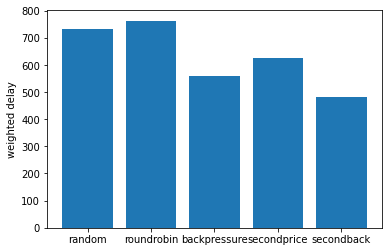

In [104]:

total_pay = np.array(data_avg_wait) + np.array(data_avg_rev)
agent_pay = np.array(data_avg_wait) + np.array(data_avg_pay)

fig, ax = plt.subplots()
ax.bar(methods, data_avg_wait)
ax.set_ylabel("weighted delay")

Text(0, 0.5, 'stdev weighted delay')

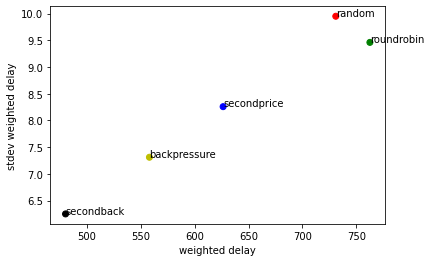

In [106]:
methods = ["random", "roundrobin", "backpressure", "secondprice", "secondback"]

fig, ax = plt.subplots()
ax.scatter(np.array(data_avg_wait), data_avg_std_weighted, color=["r", "g", "y", "b", "k"])

for i, txt in enumerate(methods):
    ax.annotate(txt, (np.array(data_avg_wait)[i], data_avg_std_weighted[i]))

ax.set_xlabel("weighted delay")
ax.set_ylabel("stdev weighted delay")

In [79]:
np.array(data_avg_pay) - np.array(data_avg_rev)

array([323.04, 308.37, 270.65, 318.75, 313.31])

[]

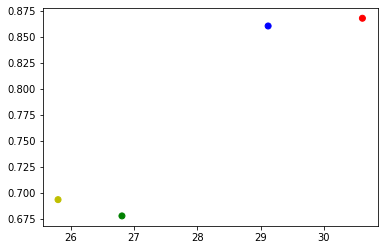

In [46]:
# plot delay vs std dev delay - random
plt.scatter([30.61, 26.81, 25.8, 29.12], [0.867633910540443, 0.6777778776095369,0.6934192773262928, 0.8601963539036589], color=["r", "g", "y","b"]) # random, roundrobin, backpress, secondprice
plt.plot()

[]

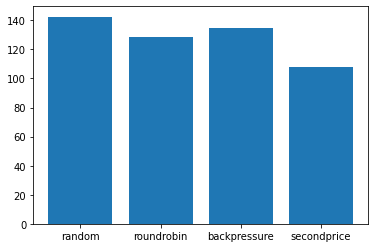

In [47]:
# plot economic efficiency - random
methods = ["random", "roundrobin", "backpressure", "secondprice"]
wait_costs = [142.49, 128.85, 134.99, 108.15]
plt.bar(methods, wait_costs)
plt.plot()

In [ ]:
layout = Layout(layout_pointy, Point(1, 1), Point(0, 0))
locations = {}
temp = True
step = [Hex(2, -1, -1), Hex(3, -1, -2)]
for h in step:
# for h in agents[3]._steps:
    locations[h] = (3, temp)
    temp = False

temp = True
for h in agents[16]._steps:
    locations[h] = (16, temp)
    temp = False

# temp = True
# for h in agents[2]._steps:
#     locations[h] = (2, temp)
#     temp = False
    
plot_locations(layout, grid.coords_l, locations)

### Running TTD for this codebase/some other thoughts

- grid cleanup - checking for legal moves
    - ~~create larger grids automagically~~
    - ~~create random agent paths~~
    - implement agent metrics
- ~~try this on larger scale problems - >3 agents, with >3 steps and targets - but WITHOUT cycles or backpressure yet~~
- implement different prioritization functions
    - round robin, backpressure
    - accrued delay
- Replicate Chris's results see if you can get similar plots (this'll take a bit but doable)
- try a VCG auction setup and see if it works
    - run theoretical framing of this process - can you mathematically express this
    - then run the pieces beneath - try proving efficiency and truthfulness w/ VCG
- implement with different operators to get dominant resource fairness (DRF)



In [ ]:
def agents_3_test_grid(radius = 1, iters = 10):
    """
    A standard test of 3 agents going across each other meeting in the middle
    """
    agent1 = Agent(Hex(0, -radius, radius), Hex(0, radius, -radius), 1)
    agent2 = Agent(Hex(-radius, 0, radius), Hex(radius, 0, -radius), 1)
    agent3 = Agent(Hex(-radius, radius, 0), Hex(radius, -radius, 0), 1)
    
    agents = [agent1, agent2, agent3]
    grid = Grid(radius)
    
    for k in range(iters):
        print(f"Cycle {k}")

        bids = [el.bid for el in agents]
        commands = grid.step_sim(bids)
        print("Commands:", commands)

        for i, command in enumerate(commands):
            agents[i].move(command)

        print("Total Revenue: ", grid.revenue)
        print("\n")

    for i, agent in enumerate(agents):
        print("Agent ", i, " costed ", agent.costs)   # think of this as extra/delayed costs
    print("Total Revenue: ", grid.revenue)

agents_3_test_grid(radius = 3)